### Confusion Matrix for Multi-Class Classification

In [1]:
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.appName('ml-cls').getOrCreate()

In [3]:
df = spark.read.csv('D://DataSets//iris.csv', header = True, inferSchema = True)
df.printSchema()

root
 |-- sepalLength: double (nullable = true)
 |-- sepalWidth: double (nullable = true)
 |-- petalLength: double (nullable = true)
 |-- petalWidth: double (nullable = true)
 |-- variety: string (nullable = true)



In [28]:
print((df.count(), len(df.columns)))

(150, 5)


In [49]:
lbls = [data[0] for data in df.select('variety').distinct().collect()]
lbls.sort()
lbls

['Setosa', 'Versicolor', 'Virginica']

In [13]:
import pyspark.sql.functions as F 

In [15]:
# to know the count of each class
df.groupby(df.variety).agg(F.count('variety')).show()

+----------+--------------+
|   variety|count(variety)|
+----------+--------------+
| Virginica|            50|
|    Setosa|            50|
|Versicolor|            50|
+----------+--------------+



In [29]:
#Separating independant variable and dependent variable("Species")
X = df.drop('variety')
y = df['variety']

In [36]:
X.show()

+-----------+----------+-----------+----------+
|sepalLength|sepalWidth|petalLength|petalWidth|
+-----------+----------+-----------+----------+
|        5.1|       3.5|        1.4|       0.2|
|        4.9|       3.0|        1.4|       0.2|
|        4.7|       3.2|        1.3|       0.2|
|        4.6|       3.1|        1.5|       0.2|
|        5.0|       3.6|        1.4|       0.2|
|        5.4|       3.9|        1.7|       0.4|
|        4.6|       3.4|        1.4|       0.3|
|        5.0|       3.4|        1.5|       0.2|
|        4.4|       2.9|        1.4|       0.2|
|        4.9|       3.1|        1.5|       0.1|
|        5.4|       3.7|        1.5|       0.2|
|        4.8|       3.4|        1.6|       0.2|
|        4.8|       3.0|        1.4|       0.1|
|        4.3|       3.0|        1.1|       0.1|
|        5.8|       4.0|        1.2|       0.2|
|        5.7|       4.4|        1.5|       0.4|
|        5.4|       3.9|        1.3|       0.4|
|        5.1|       3.5|        1.4|    

In [37]:
from pyspark.ml.feature import StringIndexer
df1 = StringIndexer(inputCol="variety", outputCol="variety_n").fit(df)

In [41]:
indexer = StringIndexer(inputCol='variety', outputCol='variety_n').fit(df)
df1 = indexer.transform(df)
df1.show(5)

DataFrame[sepalLength: double, sepalWidth: double, petalLength: double, petalWidth: double, variety: string, variety_n: double]

In [30]:
from pyspark.ml.feature import VectorAssembler

In [42]:
assembler = VectorAssembler(inputCols=X.columns, outputCol='features')
transformed_data = assembler.transform(df1)
transformed_data.show(5, truncate=False)

+-----------+----------+-----------+----------+-------+---------+-----------------+
|sepalLength|sepalWidth|petalLength|petalWidth|variety|variety_n|features         |
+-----------+----------+-----------+----------+-------+---------+-----------------+
|5.1        |3.5       |1.4        |0.2       |Setosa |0.0      |[5.1,3.5,1.4,0.2]|
|4.9        |3.0       |1.4        |0.2       |Setosa |0.0      |[4.9,3.0,1.4,0.2]|
|4.7        |3.2       |1.3        |0.2       |Setosa |0.0      |[4.7,3.2,1.3,0.2]|
|4.6        |3.1       |1.5        |0.2       |Setosa |0.0      |[4.6,3.1,1.5,0.2]|
|5.0        |3.6       |1.4        |0.2       |Setosa |0.0      |[5.0,3.6,1.4,0.2]|
+-----------+----------+-----------+----------+-------+---------+-----------------+
only showing top 5 rows



In [50]:
# Split the data
(X_train, X_test) = transformed_data.randomSplit([0.8,0.2])

In [53]:
from pyspark.ml.classification import DecisionTreeClassifier
clf = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'variety_n', maxDepth = 3)

In [54]:
model = clf.fit(X_train)

In [56]:
#Testing the model using X_test and storing the output in y_pred
predictions = model.transform(X_test)
predictions.select(predictions.columns).show(5)

+-----------+----------+-----------+----------+-------+---------+-----------------+--------------+-------------+----------+
|sepalLength|sepalWidth|petalLength|petalWidth|variety|variety_n|         features| rawPrediction|  probability|prediction|
+-----------+----------+-----------+----------+-------+---------+-----------------+--------------+-------------+----------+
|        4.4|       3.2|        1.3|       0.2| Setosa|      0.0|[4.4,3.2,1.3,0.2]|[39.0,0.0,0.0]|[1.0,0.0,0.0]|       0.0|
|        4.6|       3.1|        1.5|       0.2| Setosa|      0.0|[4.6,3.1,1.5,0.2]|[39.0,0.0,0.0]|[1.0,0.0,0.0]|       0.0|
|        4.7|       3.2|        1.6|       0.2| Setosa|      0.0|[4.7,3.2,1.6,0.2]|[39.0,0.0,0.0]|[1.0,0.0,0.0]|       0.0|
|        4.8|       3.0|        1.4|       0.1| Setosa|      0.0|[4.8,3.0,1.4,0.1]|[39.0,0.0,0.0]|[1.0,0.0,0.0]|       0.0|
|        4.8|       3.1|        1.6|       0.2| Setosa|      0.0|[4.8,3.1,1.6,0.2]|[39.0,0.0,0.0]|[1.0,0.0,0.0]|       0.0|
+-------

In [57]:
predictions.groupBy('variety_n', 'prediction').count().show()

+---------+----------+-----+
|variety_n|prediction|count|
+---------+----------+-----+
|      1.0|       1.0|    7|
|      2.0|       2.0|   13|
|      2.0|       1.0|    1|
|      1.0|       2.0|    1|
|      0.0|       0.0|   11|
+---------+----------+-----+



In [59]:
y_test = predictions.select('variety_n').rdd.flatMap(list).collect()
y_pred = predictions.select('prediction').rdd.flatMap(list).collect()

In [60]:
from sklearn.metrics import confusion_matrix
# Creating  a confusion matrix,which compares the y_test and y_pred
cm = confusion_matrix(y_test, y_pred)
cm

array([[11,  0,  0],
       [ 0,  7,  1],
       [ 0,  1, 13]], dtype=int64)

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

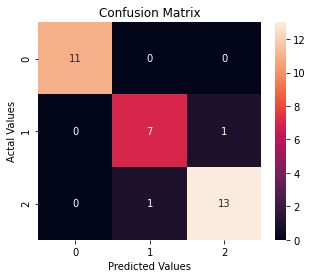

In [64]:
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [65]:
#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## F1-score:

It combines precision and recall into a single measure. Mathematically it’s the harmonic mean of precision and recall. It can be calculated as follows:
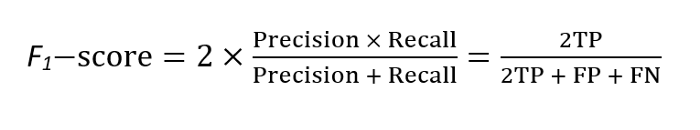
Now, in a perfect world, we’d want a model that has a precision of 1 and a recall of 1. 

That means a F1-score of 1, i.e. a 100% accuracy which is often not the case for a machine learning model. 

So what we should try, is to get a higher precision with a higher recall value. 

Okay, now that we know about the performance measures for confusion matrix, Let’s see how we can use that in a multi-class machine learning model.

### Micro F1
This is called micro-averaged F1-score. It is calculated by considering the total TP, total FP and total FN of the model. It does not consider each class individually, It calculates the metrics globally. So for our example,
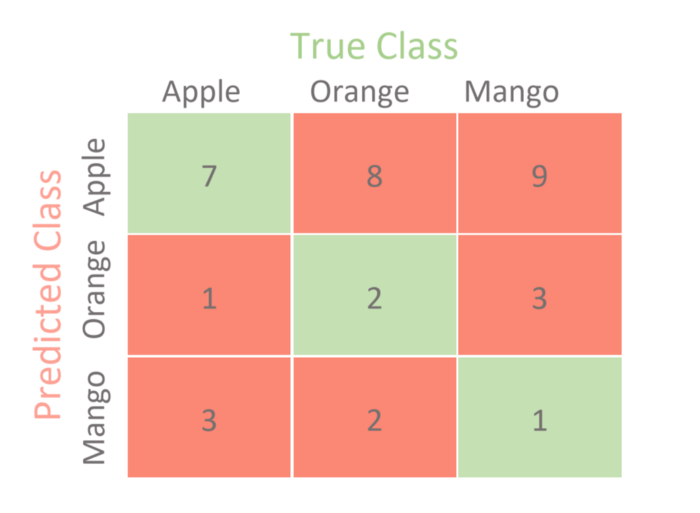

Total TP = (7+2+1) = 10

Total FP = (8+9)+(1+3)+(3+2) = 26

Total FN = (1+3)+(8+2)+(9+3) = 26

Hence,

Precision = 10/(10+26) = 0.28

Recall = 10/(10+26) = 0.28

### Macro F1
This is macro-averaged F1-score. It calculates metrics for each class individually and then takes unweighted mean of the measures. 

So for our example,

Class Apple F1-score = 0.40

Class Orange F1-score = 0.22

Class Mango F1-score = 0.11

Hence,

Macro F1 = (0.40+0.22+0.11)/3 = 0.24

### Weighted F1
The last one is weighted-averaged F1-score. Unlike Macro F1, it takes a weighted mean of the measures. 

The weights for each class are the total number of samples of that class. 

Since we had 11 Apples, 12 Oranges and 13 Mangoes,

Weighted F1 = ((0.40*11)+(0.22*12)+(0.11*13))/(11+12+13) = 0.24



In [66]:
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, target_names=lbls))


Accuracy: 0.94

Micro Precision: 0.94
Micro Recall: 0.94
Micro F1-score: 0.94

Macro Precision: 0.93
Macro Recall: 0.93
Macro F1-score: 0.93

Weighted Precision: 0.94
Weighted Recall: 0.94
Weighted F1-score: 0.94

Classification Report

              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00        11
  Versicolor       0.88      0.88      0.88         8
   Virginica       0.93      0.93      0.93        14

    accuracy                           0.94        33
   macro avg       0.93      0.93      0.93        33
weighted avg       0.94      0.94      0.94        33

